In [1]:
import jax 
jax.config.update('jax_platform_name', 'cpu')
import numpyro
numpyro.set_host_device_count(4)

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az

import sys
sys.path.append('..')
from ukraine_sentiment.graphing import config_matplotlib
config_matplotlib()

# Model Setup

Consider a fully-connected network -- regions in a country. Information travels instantaneously through the network according to edge weights, given in an attention matrix $A$, with elements: $a_{i,j} \in [0, 1]$ and $a_{i,i} = 1$. That is, regions always pay attention to themselves, and pay attention to other regions with some scaling factor.

The country is at war, and attacks occur at nodes in the network. These attacks cause fear throughout the network. Call the impact on fear of an attack $\epsilon_t$. The effect on any location in the network will be $R\epsilon_t$, because information about the attack travels instantly. Fear will increase all throughout the network, but unevenly, since not all nodes pay the same amount of attention to the attacked node.

Attacks do not occur every period. Define an indicator variable $\varphi_t$ that takes a value of 1 if an attack occurs, and 0 otherwise.

Assume that the fear signal is imperfectly observed, so that there is also some i.i.d white noise, $\eta_t$. 

Finally, assume that fear within a region lingers for some time, independently of any other region. The degree of lingering will be $\Gamma$, with $\gamma_{i,i} \in [0, 1)$ and $\gamma_{i,j} = 0$.

$$x_{t+1} = \Gamma x_t + \varphi_tR\epsilon_t + \eta_t$$

with
$$\begin{align} \epsilon_t & \sim N(0, Q) \\
                    \eta_t & \sim N(0, \Sigma) \end{align}$$
                    
The attention matrix $R$ can be brought into the covariance of $\epsilon$; define $nu_t \sim N(0, RQR^T)$, then:

$$x_{t+1} = \Gamma x_t + \varphi_t \nu_t + \eta_t$$

Also I guess $\Sigma$ should be diagonal.

In [2]:
from scipy.special import expit
n_regions = 10
T = 365

rng = np.random.default_rng(sum(map(ord, 'VAR test')))

true_Γ = np.diag(expit(rng.normal(scale=3, size=n_regions)))
true_R = expit(rng.normal(scale=3, size=((n_regions, n_regions))))
true_R[np.diag_indices_from(true_R)] = 1

true_Σ = np.diag(rng.gamma(2, 1, size=(n_regions)))
true_obs_Σ = np.diag(rng.gamma(2, 1, size=(n_regions)))
true_Q = rng.normal(scale=1, size=(n_regions, n_regions))
true_Q = true_Q @ true_Q.T
true_Q = true_Q / np.linalg.norm(true_Q)

true_intercept = rng.normal(loc=-2, scale=1, size=n_regions)

true_p_attack = rng.uniform(0, 1, size=n_regions)
attack_data = rng.binomial(1, true_p_attack, size=(T, n_regions))

data = np.zeros((T, n_regions, 1))
observed = np.zeros((T, n_regions, 1))

data[0, ...] = rng.normal(loc=-2, scale=2, size=(n_regions, 1))

for t in range(T-1):
#     nu = rng.multivariate_normal(mean=np.zeros(n_regions), cov= true_R @ true_Q @ true_R.T)
#     eta = rng.multivariate_normal(mean=np.zeros(n_regions), cov=true_Σ)
    obs_noise = rng.multivariate_normal(mean=np.zeros(n_regions), cov=true_obs_Σ)
    
    R_attack = np.diag(attack_data[t])    
    assert np.allclose(R_attack @ true_Σ, attack_data[t] * true_Σ)
    
    joint_cov = R_attack @ true_Σ + true_R @ true_Q @ true_R.T
    
    shock = rng.multivariate_normal(mean=np.zeros(n_regions), cov=joint_cov)
    data[t+1] = true_intercept[:, None] + true_Γ @ data[t, None] + shock[:, None]
    observed[t] = data[t] + obs_noise[:, None]
    
fear_index = expit(observed[..., 0]) * 100

In [3]:
from scipy.special import logit
np.allclose(logit(fear_index / 100), observed[..., 0])

True

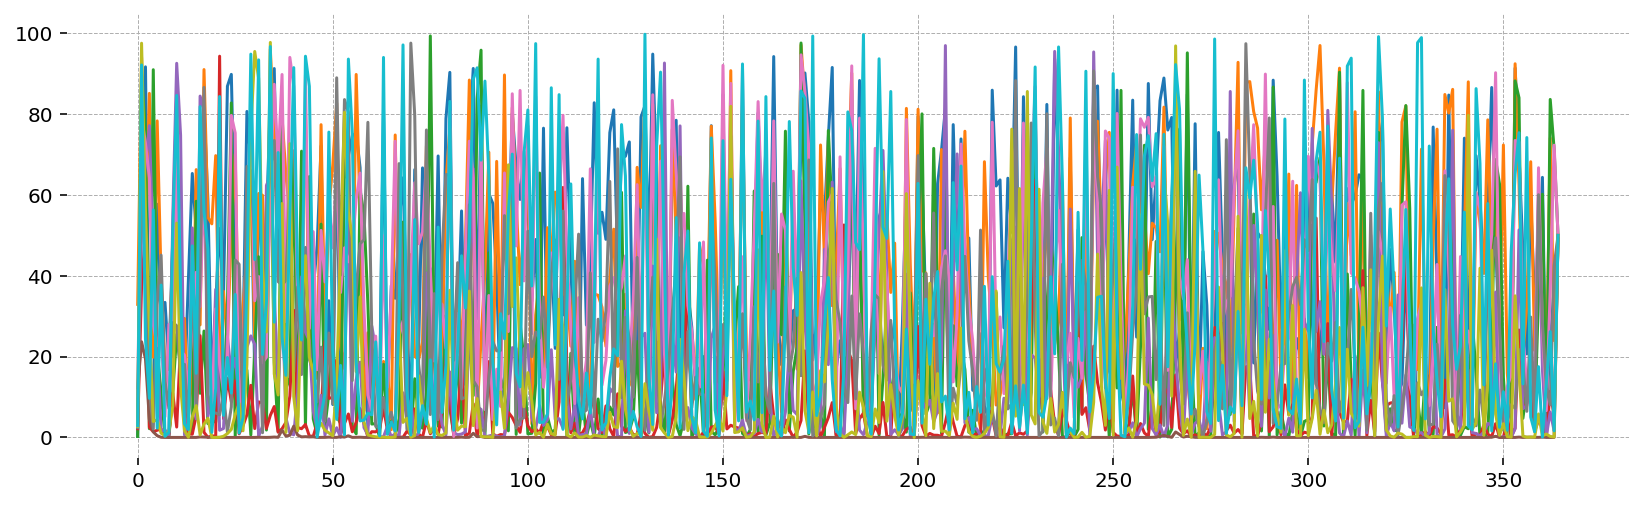

In [ ]:
plt.plot(fear_index);

## Parameter Recovery

In [5]:
from pytensor.link.jax.dispatch import jax_funcify
from pytensor.tensor.basic import Tri
import jax.numpy as jnp
from pytensor.graph.basic import Constant

@jax_funcify.register(Tri)
def jax_funcify_Tri(op, node, **kwargs):
    tri_args = node.inputs
    constant_args = []
    for arg in tri_args:
        if not isinstance(arg, Constant):
            raise NotImplementedError(f'The argument {arg} to Tri is not constant and cannot be converted to JAX')

        constant_args.append(arg.value)

    M, N, K = constant_args
    def tri(*_):
        return jnp.tri(N, M, k)

    return tri

In [8]:
import statsmodels.api as sm
mod = sm.tsa.VARMAX(observed[..., 0], order=(1, 0), measurement_error=True)
res = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          175     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07910D+01    |proj g|=  3.09255D-01


 This problem is unconstrained.



At iterate    5    f=  1.95942D+01    |proj g|=  5.69886D-01

At iterate   10    f=  1.93140D+01    |proj g|=  8.75465D-01

At iterate   15    f=  1.92033D+01    |proj g|=  7.83694D-02

At iterate   20    f=  1.91717D+01    |proj g|=  6.99294D-02

At iterate   25    f=  1.91605D+01    |proj g|=  5.20673D-02

At iterate   30    f=  1.91561D+01    |proj g|=  4.69866D-02

At iterate   35    f=  1.91534D+01    |proj g|=  4.46804D-02

At iterate   40    f=  1.91511D+01    |proj g|=  1.97919D-01

At iterate   45    f=  1.91483D+01    |proj g|=  1.43804D-01


/Users/jessegrabowski/mambaforge/envs/ukraine-sentiment/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.91438D+01    |proj g|=  6.43133D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  175     50     58      1     0     0   6.431D-02   1.914D+01
  F =   19.143840245027295     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


(array([ 33.,  66., 116., 115., 145., 144., 152., 127.,  75.,  27.]),
 array([0.04001113, 0.13332348, 0.22663583, 0.31994819, 0.41326054,
        0.50657289, 0.59988524, 0.69319759, 0.78650994, 0.87982229,
        0.97313464]),
 <BarContainer object of 10 artists>)

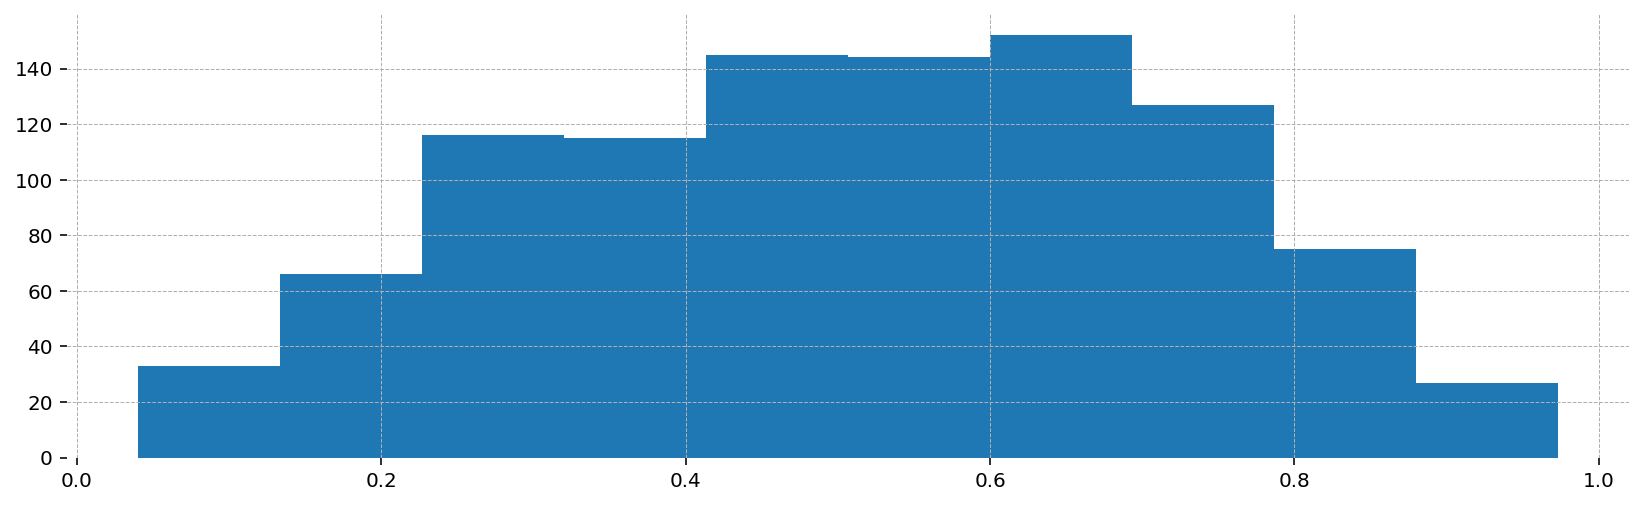

In [26]:
plt.hist(pm.draw(r_offdiag, 1000)[:, 0])

In [ ]:
from pytensor.compile.mode import get_mode
from pymc.pytensorf import collect_default_updates

k = n_regions * (n_regions - 1)

with pm.Model(check_bounds=False) as model:    
    attack_pt = pm.ConstantData('attacks', attack_data)
    obs_pt = pm.ConstantData('observed_data', observed[..., 0])
    
    logit_gammas = pm.Normal('logit_gamma', size=n_regions)
    gammas = pm.Deterministic('gamma', pm.math.invlogit(logit_gammas))
    
    logit_r_offdiag = pm.Normal('logit_r_offdiag', mu=0, sigma=1, size=k)
    r_offdiag = pm.Deterministic('r_offdiag', pm.math.invlogit(logit_r_offdiag))
    
    x0 = pm.Normal('x0', size=n_regions)
    
    R = pt.eye(n_regions)
    R = pt.set_subtensor(R[np.triu_indices(n_regions, 1)], r_offdiag[:k // 2])
    R = pt.set_subtensor(R[np.tril_indices(n_regions, -1)], r_offdiag[k // 2:])
    R = pt.specify_shape(R, (n_regions, n_regions))
    
    Γ = pt.diag(gammas)
    Γ = pt.specify_shape(Γ, (n_regions, n_regions))
    
    Q_chol, *_ = pm.LKJCholeskyCov('Q_chol', sd_dist=pm.HalfNormal.dist(sigma=3), n=n_regions, eta=10)
    Q_chol = pt.specify_shape(Q_chol, (n_regions, n_regions))
    Q = pm.Deterministic('Q', Q_chol @ Q_chol.T)
    
    RQRT = R @ Q @ R.T
    
    sigma_eta = pm.Gamma('sigma_eta', alpha=2, beta=1, size=n_regions)
    Σ = pt.diag(sigma_eta)
        
    def VAR_step(*args):
        attack, last_x, Γ, RQRT, Σ = args
        shock_cov = attack * Σ + RQRT
        x = pm.MvNormal.dist(mu=Γ @ last_x, cov=shock_cov)
        return x, collect_default_updates(args, [x])
        
    var_mean, updates = pytensor.scan(VAR_step, 
                                      sequences=attack_pt,
                                      outputs_info=[x0],
                                      non_sequences=[Γ, RQRT, Σ],
                                      strict=True,
                                      mode=get_mode("JAX"))
    
    model.register_rv(var_mean, name = 'VAR_mean', initval=pt.as_tensor_variable(res.states.filtered))
    intercept = pm.Normal('intercept', size=n_regions)
    noise_sigmas = pm.Gamma('noise_sigmas', alpha=2, beta=1, size=n_regions)

    obs = pm.Normal('obs', mu = intercept + var_mean, sigma=noise_sigmas, observed=obs_pt)
    idata = pm.sample(nuts_sampler='numpyro', nuts_sampler_kwargs={'chain_method':'parallel'}, target_accept=0.99)
    print(f'Divergences: {idata.sample_stats.diverging.sum().values}')

/Users/jessegrabowski/mambaforge/envs/ukraine-sentiment/lib/python3.11/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.347438
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

<Axes: >

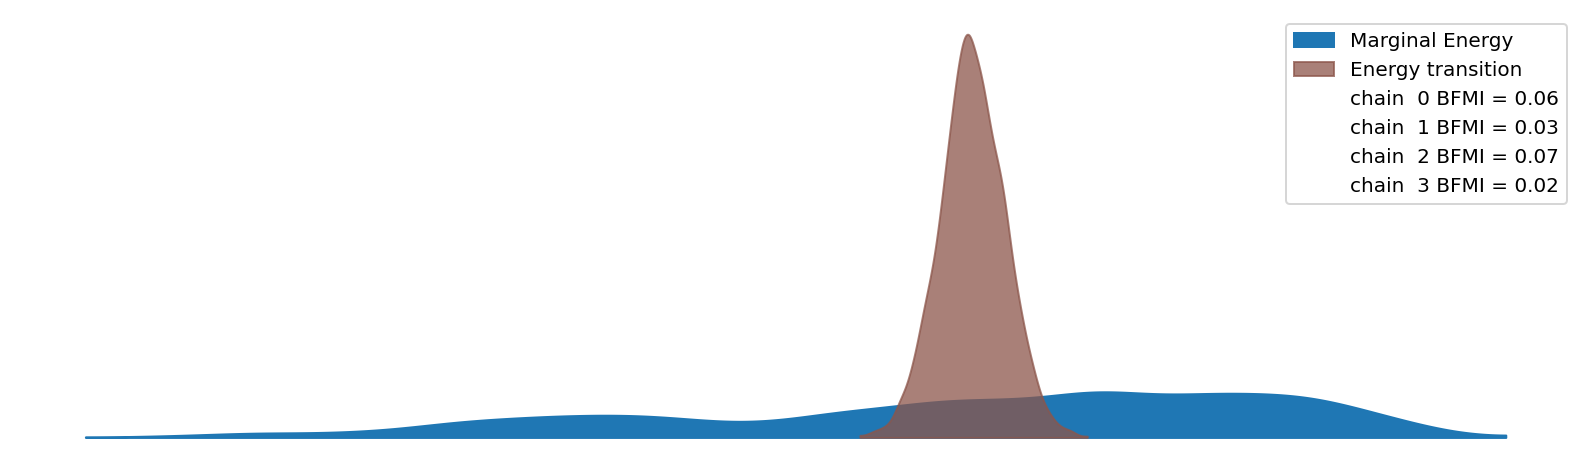

In [12]:
az.plot_energy(idata)

In [13]:
summary = az.summary(idata)

/Users/jessegrabowski/mambaforge/envs/ukraine-sentiment/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [14]:
with model:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [obs]


In [15]:
preds = az.extract(idata, 'posterior_predictive').obs
hdi = az.hdi(idata.posterior_predictive.obs).obs

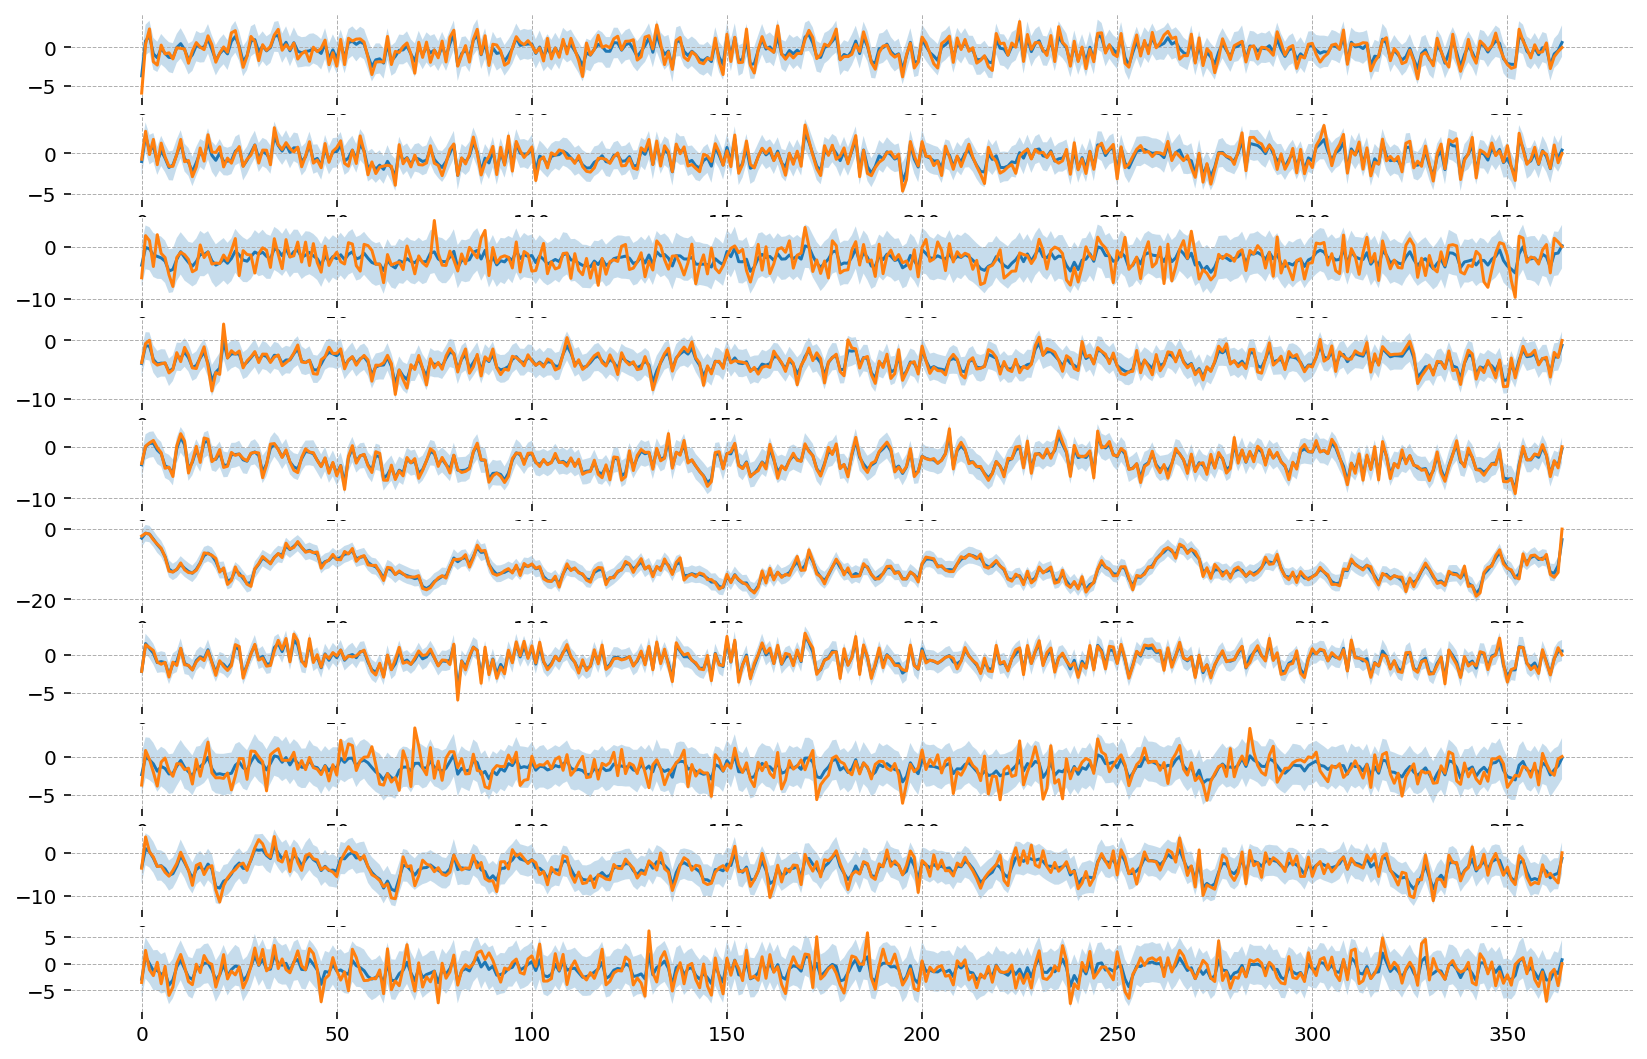

In [16]:
fig, ax = plt.subplots(n_regions, 1, figsize=(14, 9))
for i, axis in enumerate(fig.axes):
    axis.plot(preds.values.mean(axis=-1)[:, i])
    axis.fill_between(np.arange(T), *hdi.values[:, i, :].T, alpha=0.25)
    axis.plot(observed[:, i, 0])

In [17]:
r_values = np.r_[true_R[np.triu_indices(n_regions, 1)], true_R[np.tril_indices(n_regions, -1)]]

/Users/jessegrabowski/mambaforge/envs/ukraine-sentiment/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (90) in plot_posterior, generating only 40 plots
  warnings.warn(


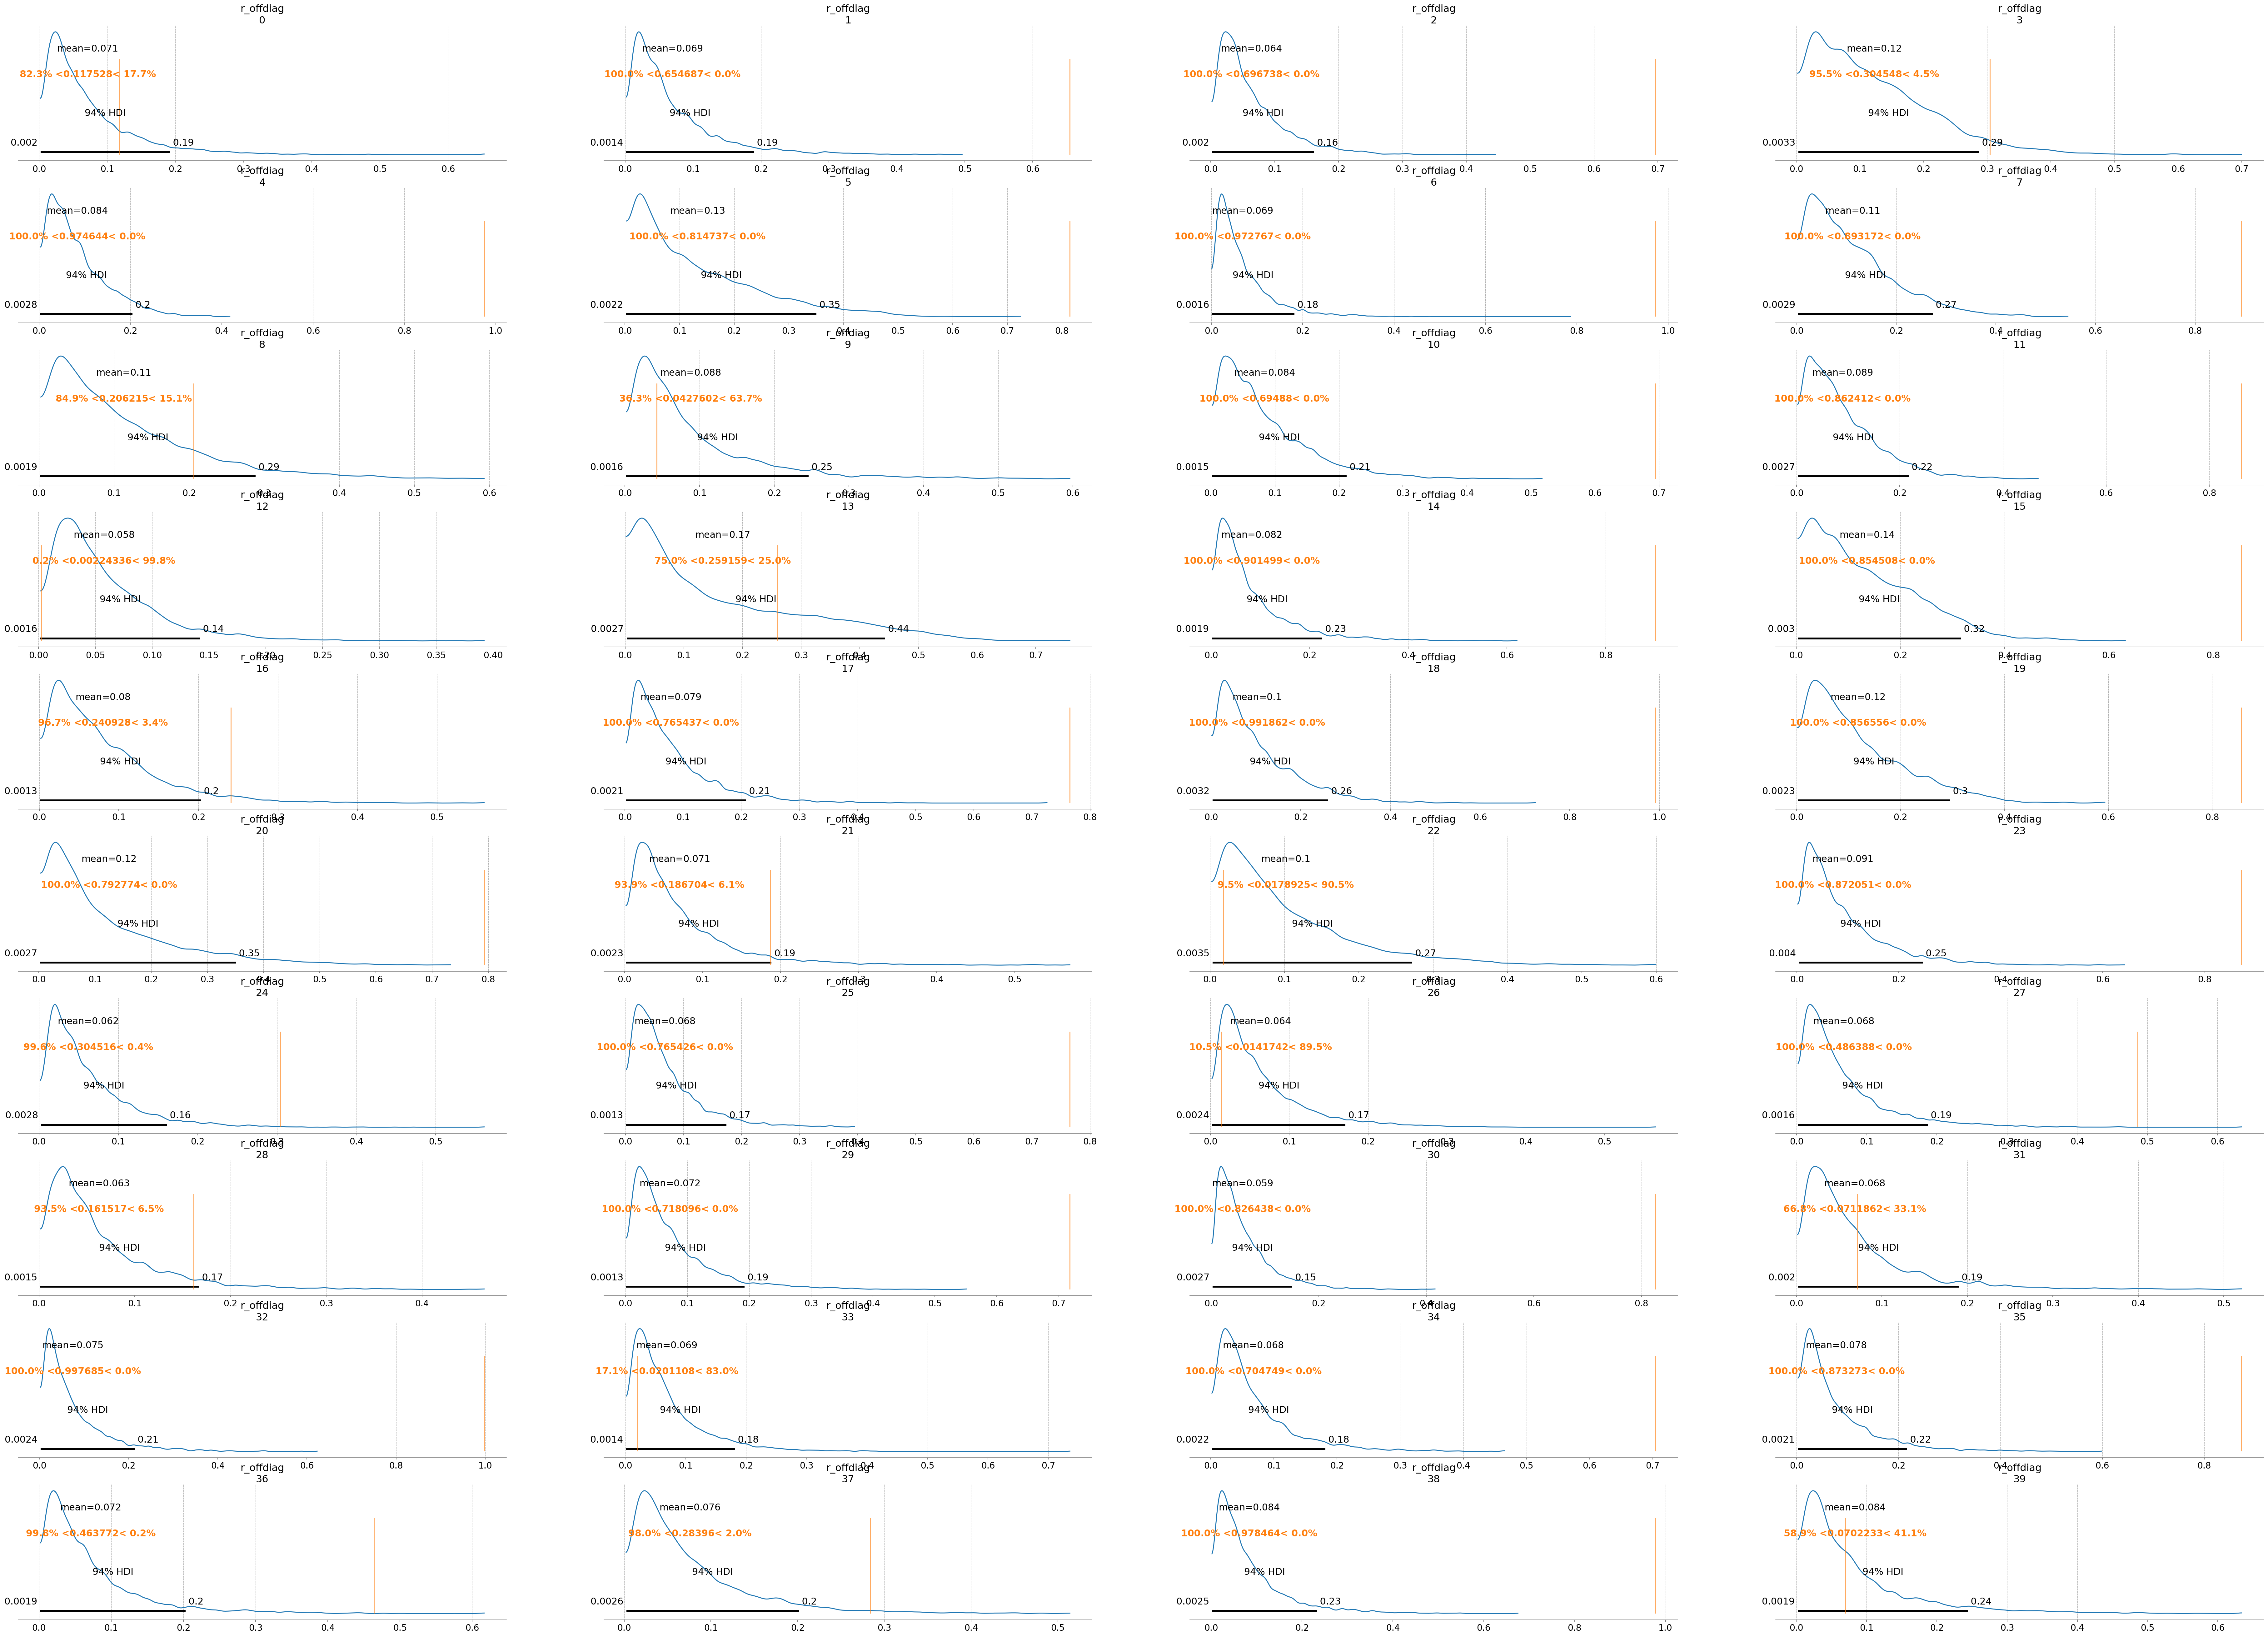

In [18]:
axes = az.plot_posterior(idata, var_names=['r_offdiag'], ref_val=r_values.tolist())
# az.plot_posterior(priors, var_names=['r_offdiag'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k')

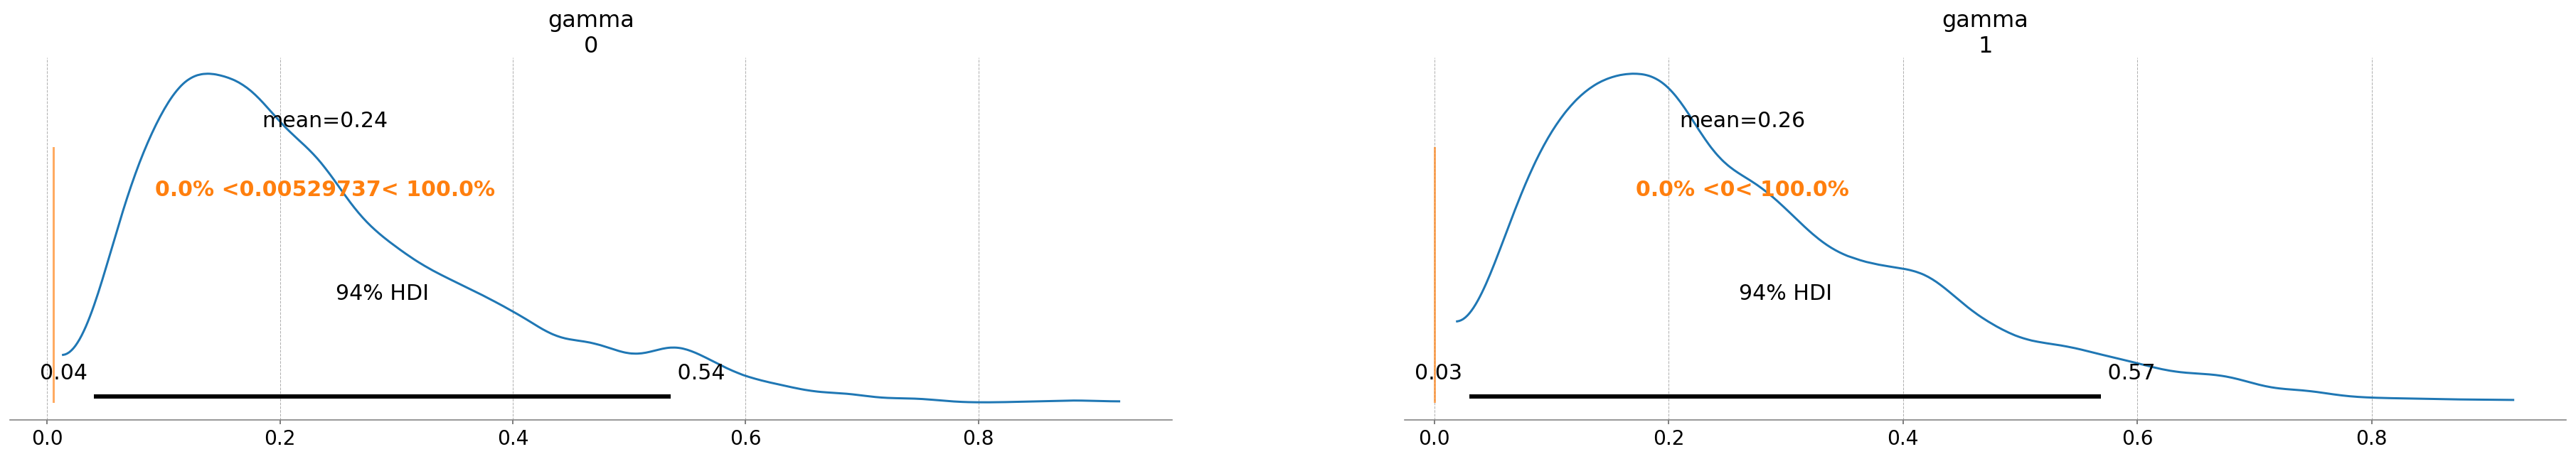

In [68]:
axes = az.plot_posterior(idata, var_names=['gamma'], ref_val=true_Γ.ravel().tolist())
# az.plot_posterior(priors, var_names=['gamma'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');

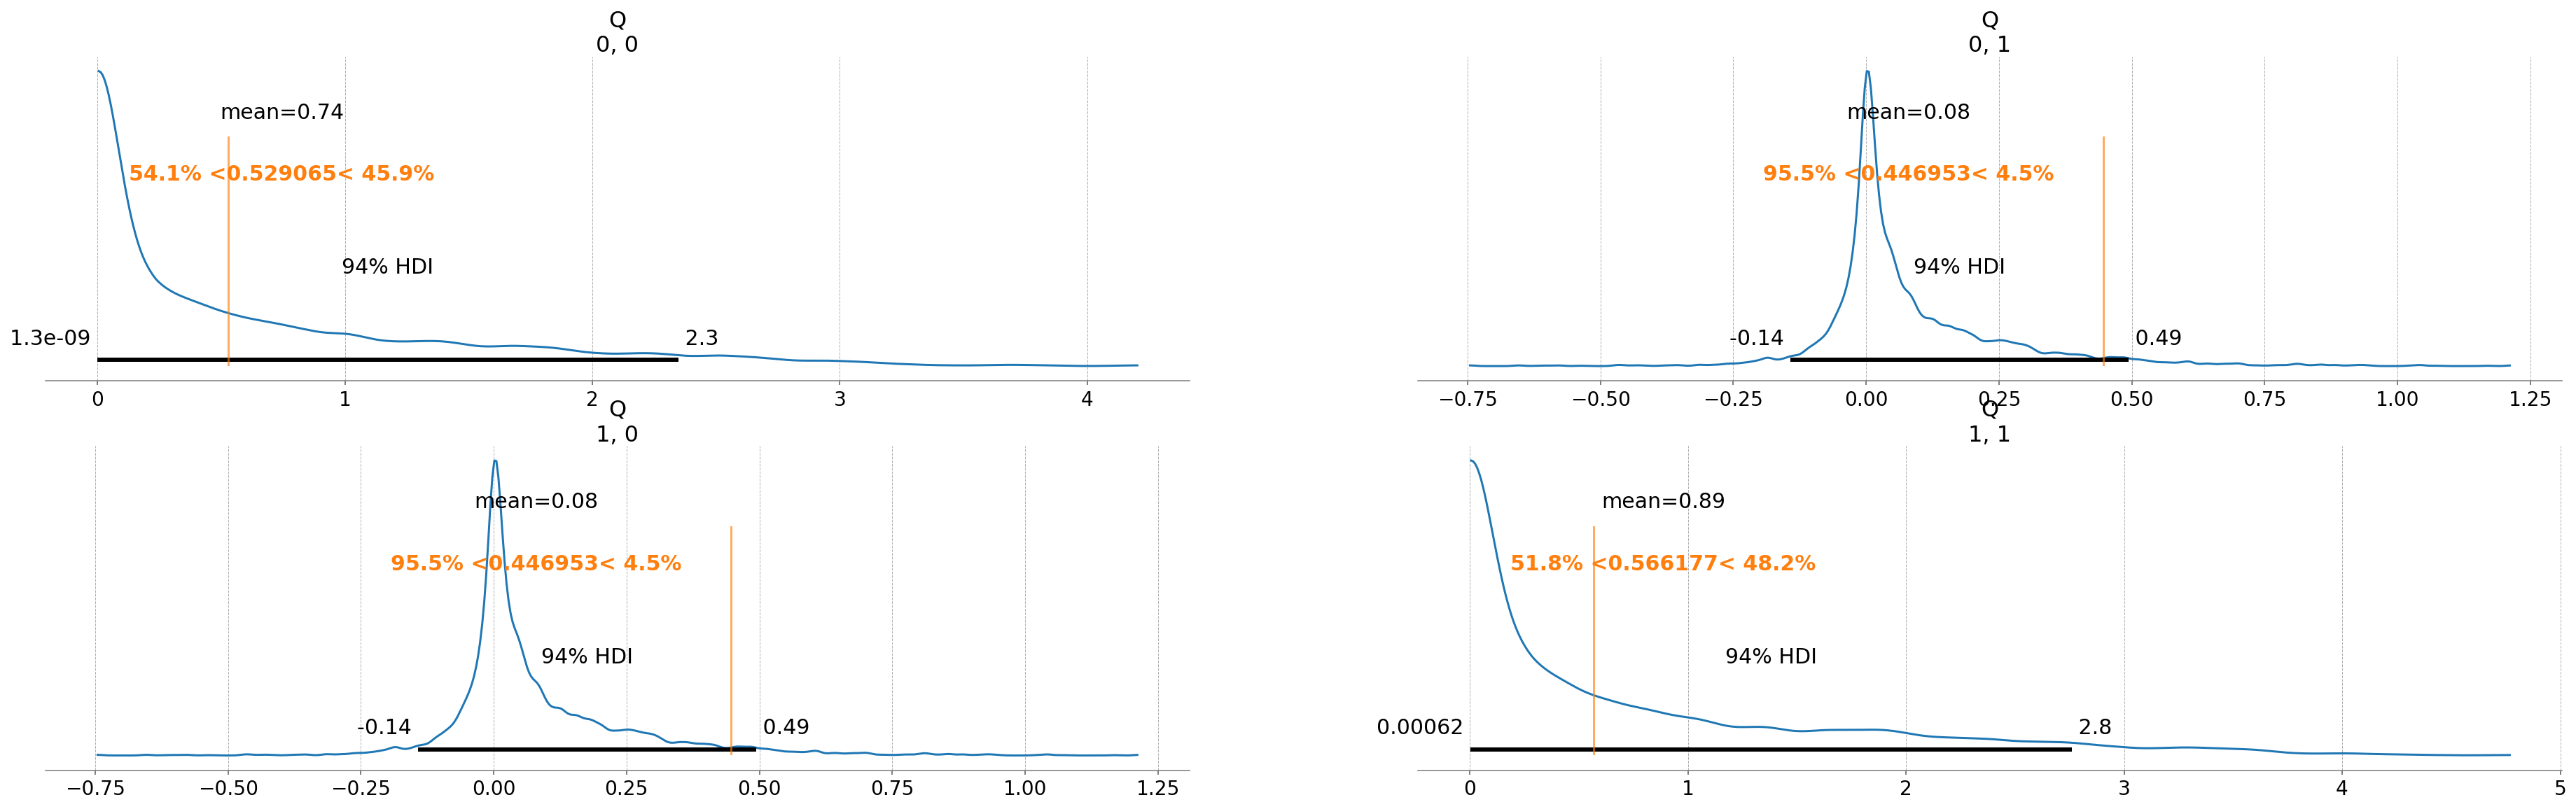

In [69]:
axes = az.plot_posterior(idata, var_names=['Q'], ref_val=true_Q.ravel().tolist(), grid=(2, 2))
# az.plot_posterior(priors, var_names=['Q'], group='prior', grid=(2,2), ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');

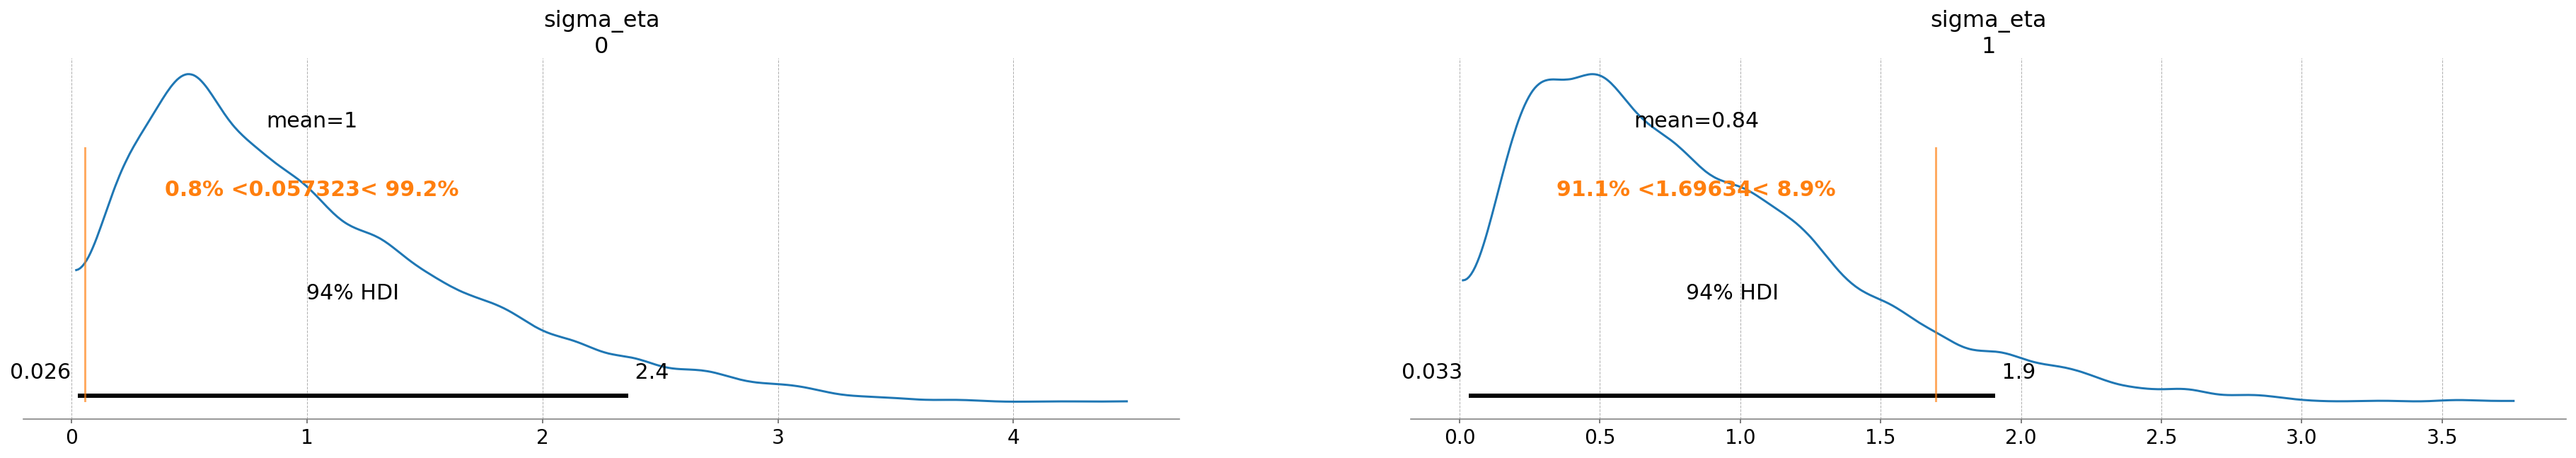

In [70]:
axes = az.plot_posterior(idata, var_names=['sigma_eta'], ref_val=np.diagonal(true_Σ).tolist())
# az.plot_posterior(priors, var_names=['sigma_eta'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');

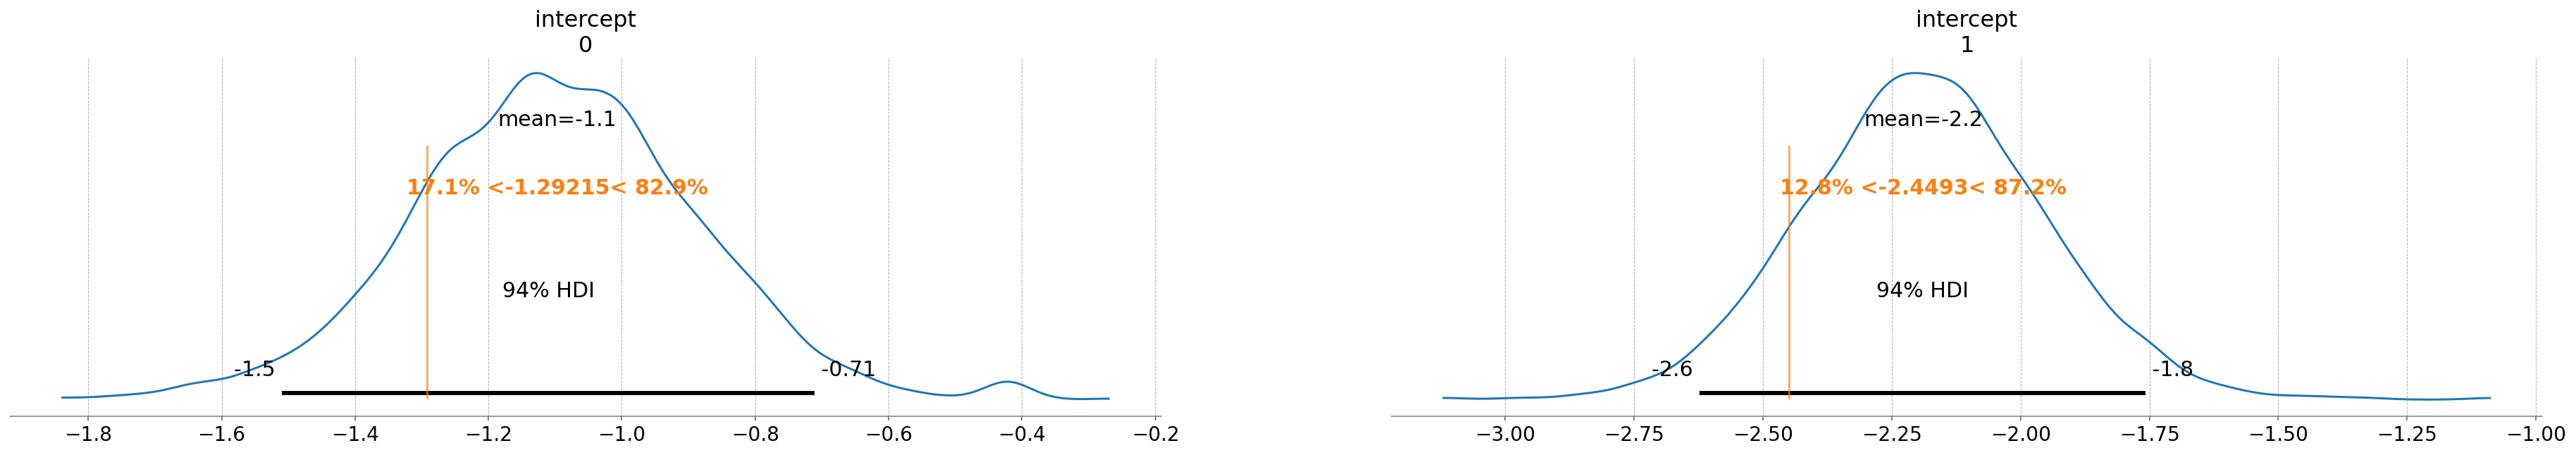

In [71]:
axes = az.plot_posterior(idata, var_names=['intercept'], ref_val=true_intercept.tolist())
# az.plot_posterior(priors, var_names=['intercept'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');